In [1]:
print("hello world")

hello world


In [2]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
print("Setup complete. Seed set to", SEED)

Setup complete. Seed set to 42


In [3]:
# Імена колонок з опису датасету
col_names = [
    "id", "clump_thickness", "uniformity_cell_size", "uniformity_cell_shape",
    "marginal_adhesion", "single_epithelial_cell_size", "bare_nuclei",
    "bland_chromatin", "normal_nucleoli", "mitoses", "class"
]

# Завантажуємо .data
df = pd.read_csv("breast-cancer-wisconsin.data", names=col_names)

print("Розмір датасету без обробки:", df.shape)
print(df.head())

Розмір датасету без обробки: (699, 11)
        id  clump_thickness  uniformity_cell_size  uniformity_cell_shape  \
0  1000025                5                     1                      1   
1  1002945                5                     4                      4   
2  1015425                3                     1                      1   
3  1016277                6                     8                      8   
4  1017023                4                     1                      1   

   marginal_adhesion  single_epithelial_cell_size bare_nuclei  \
0                  1                            2           1   
1                  5                            7          10   
2                  1                            2           2   
3                  1                            3           4   
4                  3                            2           1   

   bland_chromatin  normal_nucleoli  mitoses  class  
0                3                1        1      2  
1    

In [4]:

df["bare_nuclei"] = pd.to_numeric(df["bare_nuclei"], errors="coerce")

# Прибираємо рядки з пропущеними значеннями
df = df.dropna()

# Remove id
df = df.drop(columns=["id"])

# Формуємо X та y
X = df.drop(columns=["class"]).values
y = df["class"].map({2: 0, 4: 1}).values   # 2→0 (benign), 4→1 (malignant)

# Статистика
num_input_feat = X.shape[1]
print("Кількість ознак:", num_input_feat)
print("Кількість об'єктів:", X.shape[0])
print("Розподіл класів:", np.bincount(y))


Кількість ознак: 9
Кількість об'єктів: 683
Розподіл класів: [444 239]


In [5]:
# Масштабуємо ознаки (нормалізація – важлива для MLP)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ділимо на train/test з стратифікацією за класом
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=SEED, stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 546
Test size: 137


In [6]:
# Numpy → Torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)

X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

for xb, yb in train_loader:
    print("Приклад батчу X:", xb.shape, "y:", yb.shape)
    break


Приклад батчу X: torch.Size([32, 9]) y: torch.Size([32])


In [8]:
class CancerMLP(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),

            nn.Linear(16, num_classes)  # logits для 2 класів
        )

    def forward(self, x):
        return self.net(x)

model = CancerMLP(num_input_feat, num_classes=2)
print(model)

# Порахуємо кількість параметрів моделі
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Кількість trainable параметрів:", total_params)


CancerMLP(
  (net): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)
Кількість trainable параметрів: 914


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

n_epochs = 30

train_loss_history = []
val_loss_history = []

for epoch in range(n_epochs):

    # trenyvannia 
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # validatsia
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()

    val_loss /= len(test_loader)

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    print(f"[{epoch+1:02d}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")




[01] train_loss=0.3688 | val_loss=0.3914
[02] train_loss=0.2764 | val_loss=0.1870
[03] train_loss=0.2315 | val_loss=0.1247
[04] train_loss=0.2048 | val_loss=0.1427
[05] train_loss=0.1769 | val_loss=0.1450
[06] train_loss=0.1171 | val_loss=0.1303
[07] train_loss=0.1543 | val_loss=0.1315
[08] train_loss=0.0959 | val_loss=0.1177
[09] train_loss=0.1133 | val_loss=0.1096
[10] train_loss=0.1042 | val_loss=0.1031
[11] train_loss=0.0932 | val_loss=0.1085
[12] train_loss=0.1786 | val_loss=0.0912
[13] train_loss=0.1169 | val_loss=0.1188
[14] train_loss=0.0866 | val_loss=0.1056
[15] train_loss=0.1053 | val_loss=0.1156
[16] train_loss=0.0753 | val_loss=0.1043
[17] train_loss=0.1680 | val_loss=0.0989
[18] train_loss=0.0888 | val_loss=0.1116
[19] train_loss=0.0977 | val_loss=0.1237
[20] train_loss=0.0712 | val_loss=0.1171
[21] train_loss=0.0693 | val_loss=0.1049
[22] train_loss=0.0738 | val_loss=0.1059
[23] train_loss=0.1922 | val_loss=0.1080
[24] train_loss=0.0921 | val_loss=0.1236
[25] train_loss=

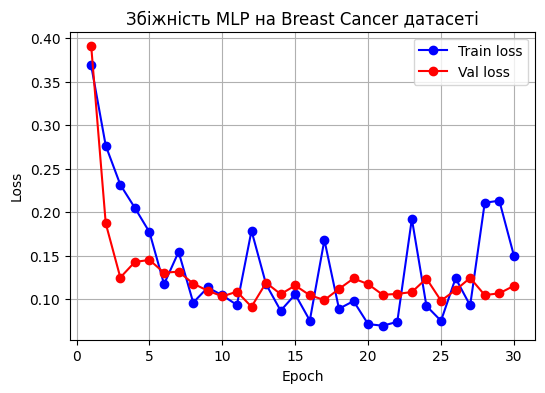

In [11]:
plt.figure(figsize=(6,4))
epochs = range(1, len(train_loss_history) + 1)
plt.plot(epochs, train_loss_history, "bo-", label="Train loss")
plt.plot(epochs, val_loss_history, "ro-", label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Збіжність MLP на Breast Cancer датасеті")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(yb.numpy())

all_preds = np.array(all_preds)
all_true = np.array(all_true)

acc = accuracy_score(all_true, all_preds)
print(f"Test Accuracy: {acc*100:.2f}%")

print("\nConfusion matrix:")
print(confusion_matrix(all_true, all_preds))

print("\nClassification report:")
print(classification_report(all_true, all_preds, target_names=["benign", "malignant"]))

Test Accuracy: 96.35%

Confusion matrix:
[[85  4]
 [ 1 47]]

Classification report:
              precision    recall  f1-score   support

      benign       0.99      0.96      0.97        89
   malignant       0.92      0.98      0.95        48

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.96      0.96      0.96       137



У лабораторній роботі 1 найкращим класичним алгоритмом був SVM, який показав точність 0.96 weighted avg для precision, recall для злоякісних пухлин. В лабораторній роботі 5 була побудована повнозв'язна нейронна мережа. Її якість виявилась на тому ж рівні. Це показує, що MLP здатна відтворити й навіть перевершити класичні алгоритми, але вимагає обережного підбору гіперпараметрів.

Висновок:
MLP за якістю дорівнює найкращому алгоритму з Лаби 1 (SVM), але є більш гнучкою моделлю, яку можна масштабувати на складні багатовимірні дані. Для цього невеликого датасету переваги MLP незначні, але при збільшенні даних саме нейромережа працюватиме краще.